## In This Notebook we will Create Figures to better understand out models performance

#### Making our working directory

In [2]:
# Set a working directory
import os

directory_path = '/Users/cristianswift/Desktop/armbrust-lab/Seaflow-Machine-Learning/'
os.chdir(directory_path)


In [3]:
%run python/04_Populations-model-fitting/01_model-preparation.ipynb


## Importing our random forest ready dataframe so that we can reapply the models to the dataset.
This will allow us to have all of the RF models in one notebook.

In [4]:
import pandas as pd

covari_path = 'data/modified/RF_ready_covari.csv'
#using pandas to read in as a df
covari = (pd.read_csv(covari_path,parse_dates=[0]))
#taking a peak at the data
covari.head(4)


time              population        lat         lon  \
0 2016-04-20 07:00:00         Prochlorococcus  21.520326 -158.326984   
1 2016-04-20 07:00:00           Synechococcus  21.520326 -158.326984   
2 2016-04-20 07:00:00  nanoeukaryotes (2-5µm)  21.520326 -158.326984   
3 2016-04-20 07:00:00  picoeukaryotes (< 2µm)  21.520326 -158.326984   

     biomass      salin       temp cruisename      SiO2       POC  ...  \
0  10.520443  34.893785  24.351745    KOK1606 -0.022845  0.032884  ...   
1   0.341429  34.893785  24.351745    KOK1606 -0.022845  0.032884  ...   
2   3.338212  34.893785  24.351745    KOK1606 -0.022845  0.032884  ...   
3   0.701902  34.893785  24.351745    KOK1606 -0.022845  0.032884  ...   

           O2       NO3       NO2       NH4       FeT       DOC          DIC  \
0  214.191393  2.252042  0.295276  1.282981  0.000015  1.648093  1697.874775   
1  214.191393  2.252042  0.295276  1.282981  0.000015  1.648093  1697.874775   
2  214.191393  2.252042  0.295276  1.282981  0.000015  1.648093  1697.874775   
3  214.191393  2.252042  0.295276  1.282981  0.000015  1.648093  1697.874775   

       CDOM         ALK     par  
0  0.000034  1954.87665  0.0193  
1  0.000034  1954.87665  0.0193  
2  0.000034  1954.87665  0.0193  
3  0.000034  1954.87665  0.0193  

[4 rows x 22 columns]

#### All of our features used in the RF models

In [5]:
covari.iloc[:,8:].columns

Index(['SiO2', 'POC', 'PO4', 'PIC', 'O2', 'NO3', 'NO2', 'NH4', 'FeT', 'DOC',
       'DIC', 'CDOM', 'ALK', 'par'],
      dtype='object')

### Now we will load each random forest model into our notebook

In [6]:
import joblib
# Prochlorooccus
rf_pro = joblib.load("RF_models/pro_random_forest.joblib")

# Synechococus
rf_syn = joblib.load("RF_models/syn_random_forest.joblib")

# Nanoeukaryotes
rf_nano = joblib.load("RF_models/nano_random_forest.joblib")

# Picoeukaryotes
rf_pico = joblib.load("RF_models/pico_random_forest.joblib")

## Developing a cruise_tract to see where all of our data comes from.

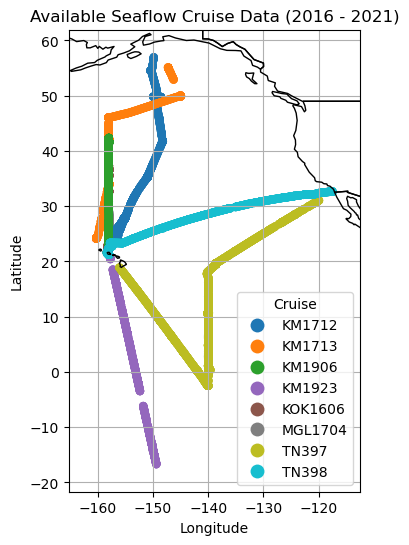

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
import contextily as cx
from shapely.geometry import Point

def cruise_tract(dataframe):
    """
    Creates a tract of all the cruises used in the dataset minus the NaN values that were present in SeaFlow.
    """
    # Create starting cruise tracks df that contains Nans
    cruise_tracks = dataframe[['time', 'lat', 'lon', 'cruisename']]

    # Creating geometry points to plot
    geometry = [Point(xy) for xy in zip(cruise_tracks['lon'], cruise_tracks['lat'])]
    gdf = GeoDataFrame(cruise_tracks, geometry=geometry, crs=3857)

    # Load the world map shapefile using GeoPandas
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Create a GeoPandas plot of the world map
    fig, ax = plt.subplots(figsize=(10, 6))
    world.boundary.plot(ax=ax, linewidth=1, color='black')  # plot the world map boundaries

    # Setting bounds of the map
    bounds = gdf.geometry.bounds
    ax.set_xlim([bounds.minx.min()-5, bounds.maxx.max()+5])
    ax.set_ylim([bounds.miny.min()-5, bounds.maxy.max()+5])

    # Use the 'cruisename' column to color the cruise tracks
    gdf.plot(column='cruisename', linewidth=0.05, ax=ax, legend=True, cmap='tab10', legend_kwds={'title': 'Cruise'})

    # Set the background color of the plot to white
    ax.set_facecolor('white')
    ax.grid()

    # Set the title and labels for the plot
    ax.set_title('Available Seaflow Cruise Data (2016 - 2021)')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Show the plot
    plt.show()

# Assuming 'cruisename' is the correct column in your 'covari' dataframe that contains the cruise names
cruise_tract(covari)


## To make residuals we will predict on all available data for each picophytoplankton's population

In [8]:
def predictions_and_residuals(rf, features, pop_df):
    """
    Takes in a specific populations random forest model, specific dataframe, and specific features list.
         This function returns the population specific dataframe with the biomass column relabed as 'actual'
         and a new column with random forest predicted values.
    """
    
    # Use the forest's predict method on the test data
    predictions = rf.predict(features)
    
    # Add 'Prediction' and 'residuals' columns to the dataframe
    pop_df.rename(columns={'biomass': 'actual'}, inplace=True)
    pop_df['prediction'] = predictions
    pop_df['residuals'] = ((pop_df['actual'] - pop_df['prediction']) / pop_df['actual']) * 100
    
    return pop_df  



pro_df = predictions_and_residuals(rf=rf_pro, features=features_pro, pop_df=pro_df)
syn_df = predictions_and_residuals(rf=rf_syn, features=features_syn, pop_df=syn_df)
nano_df = predictions_and_residuals(rf=rf_nano, features=features_nano, pop_df=nano_df)
pico_df = predictions_and_residuals(rf=rf_pico, features=features_pico, pop_df=pico_df)


In [9]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def create_actual_prediction_plots(pop_df, title_prefix='Prochlorococcus'):
    """
    Makes an actual vs prediction plot for a population speicfic random forest model.
    """
    unique_cruises = pop_df['cruisename'].unique()

    # Create a subplot grid
    num_cruises = len(unique_cruises)
    rows = int(num_cruises / 2) if num_cruises % 2 == 0 else int(num_cruises / 2) + 1
    fig = make_subplots(rows=rows, cols=2, subplot_titles=unique_cruises)

    # Define colors for 'actual' and 'prediction' traces
    actual_color = 'blue'
    prediction_color = 'red'

    # Iterate over each unique cruise and add a subplot
    for i, cruise in enumerate(unique_cruises):
        # Filter dataframe for the current cruise
        cruise_df = pop_df[pop_df['cruisename'] == cruise]

        # Add the scatter plots for 'actual' and 'prediction' to the subplot
        row = int(i / 2) + 1
        col = i % 2 + 1
        fig.add_trace(go.Scatter(x=cruise_df['time'], y=cruise_df['actual'], mode='markers', name='Actual',
                                 marker=dict(color=actual_color)),
                      row=row, col=col)
        fig.add_trace(go.Scatter(x=cruise_df['time'], y=cruise_df['prediction'], mode='lines', name='Prediction',
                                 line=dict(color=prediction_color)),
                      row=row, col=col)
        fig.update_xaxes(title_text='Time', row=row, col=col)
        fig.update_yaxes(title_text='Value', row=row, col=col)

    # Update the layout and display the figure
    fig.update_layout(height=600 * rows, width=800, title_text='Actual and Prediction for Each Cruise')
    fig.show()
    
    fig.write_html(f"figures/{title_prefix}/Actual_vs_Prediction-{title_prefix}.html")


In [10]:
create_actual_prediction_plots(pop_df=pro_df, title_prefix='Prochlorococcus')
create_actual_prediction_plots(pop_df=syn_df, title_prefix='Synechococcus')
create_actual_prediction_plots(pop_df=nano_df, title_prefix='Nanoeukaryotes')
create_actual_prediction_plots(pop_df=pico_df, title_prefix='Picoeukaryotes')

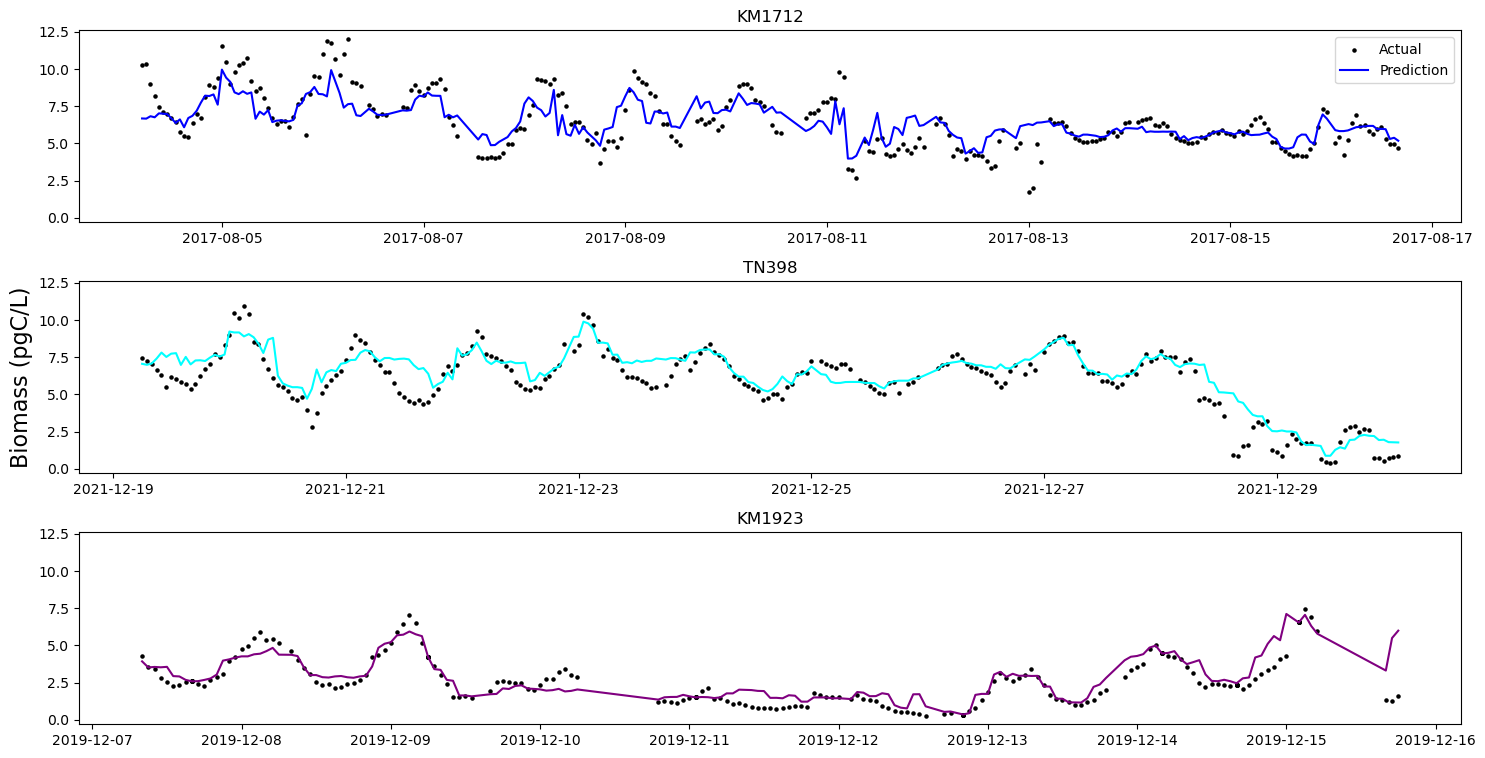

In [11]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create two subplots and unpack the output array immediately
f, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharey=True, figsize=(15,8))

km1712 = pro_df[pro_df['cruisename'] == 'KM1712']
tn398 = pro_df[pro_df['cruisename'] == 'TN398']
km1923 = pro_df[pro_df['cruisename'] == 'KM1923']

      
ax1.scatter(km1712['time'], km1712['actual'], s=5, color='black', label='Actual')
ax1.plot(km1712['time'], km1712['prediction'], color='blue', label='Prediction')

ax1.set_title('KM1712')
ax1.legend()

ax2.scatter(tn398['time'], tn398['actual'], s=5, color='black', label='Actual' )
ax2.plot(tn398['time'], tn398['prediction'], color='cyan', label='Prediction')
ax2.set_title('TN398')
ax2.set_ylabel('Biomass (pgC/L)', fontsize=16)

ax3.scatter(km1923['time'], km1923['actual'], s=5, color='black', label='Actual')
ax3.plot(km1923['time'], km1923['prediction'], color='purple', label='Prediction')
ax3.set_title('KM1923')



plt.tight_layout(rect=[0, 0, 1, 0.96])  # Add space for suptitle
plt.show()

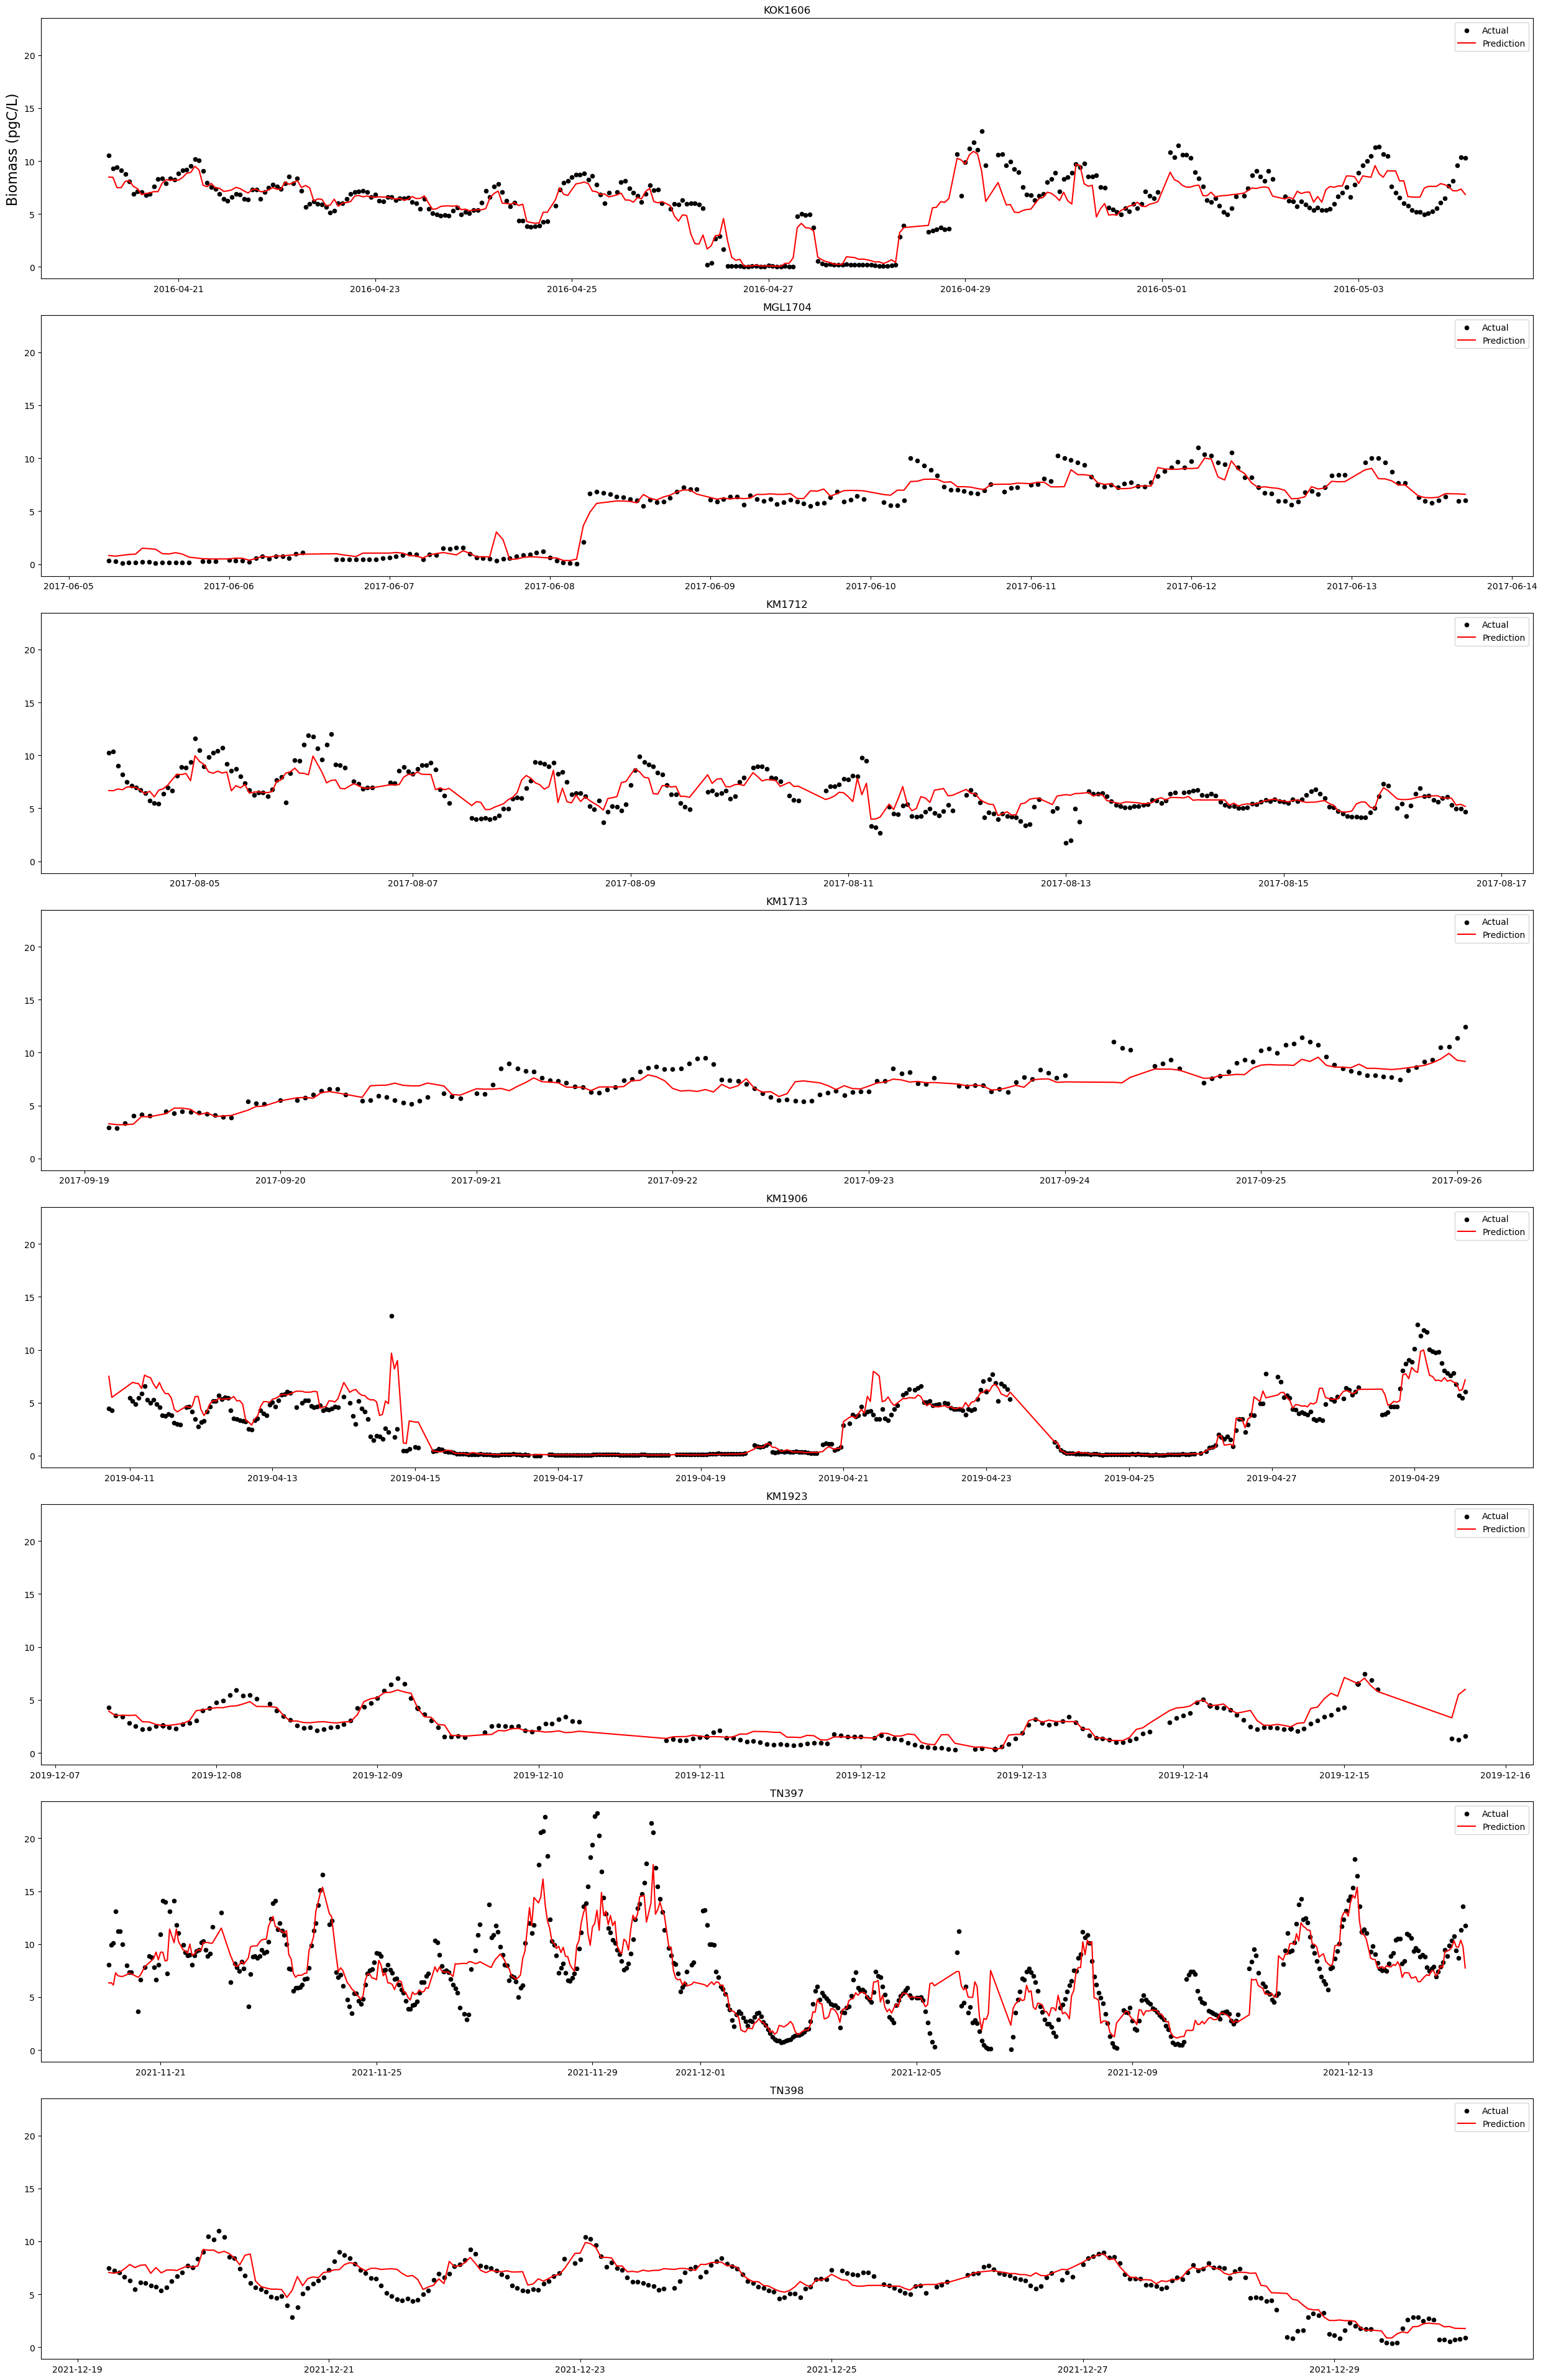

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a list of unique cruise names
unique_cruises = pro_df['cruisename'].unique()

# Create subplots dynamically based on the number of unique cruises
num_subplots = len(unique_cruises)
fig, axs = plt.subplots(nrows=num_subplots, ncols=1, sharey=True, figsize=(25, 40))

# Iterate through unique cruises and create subplots
for i, cruise_name in enumerate(unique_cruises):
    cruise_data = pro_df[pro_df['cruisename'] == cruise_name]
    
    ax = axs[i]
    ax.scatter(cruise_data['time'], cruise_data['actual'], s=20, color='black', label='Actual')
    ax.plot(cruise_data['time'], cruise_data['prediction'], color='red', label='Prediction')
    
    ax.set_title(cruise_name)
    ax.legend()

# Add a common y-axis label (if needed)
axs[0].set_ylabel('Biomass (pgC/L)', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Add space for suptitle
plt.show()


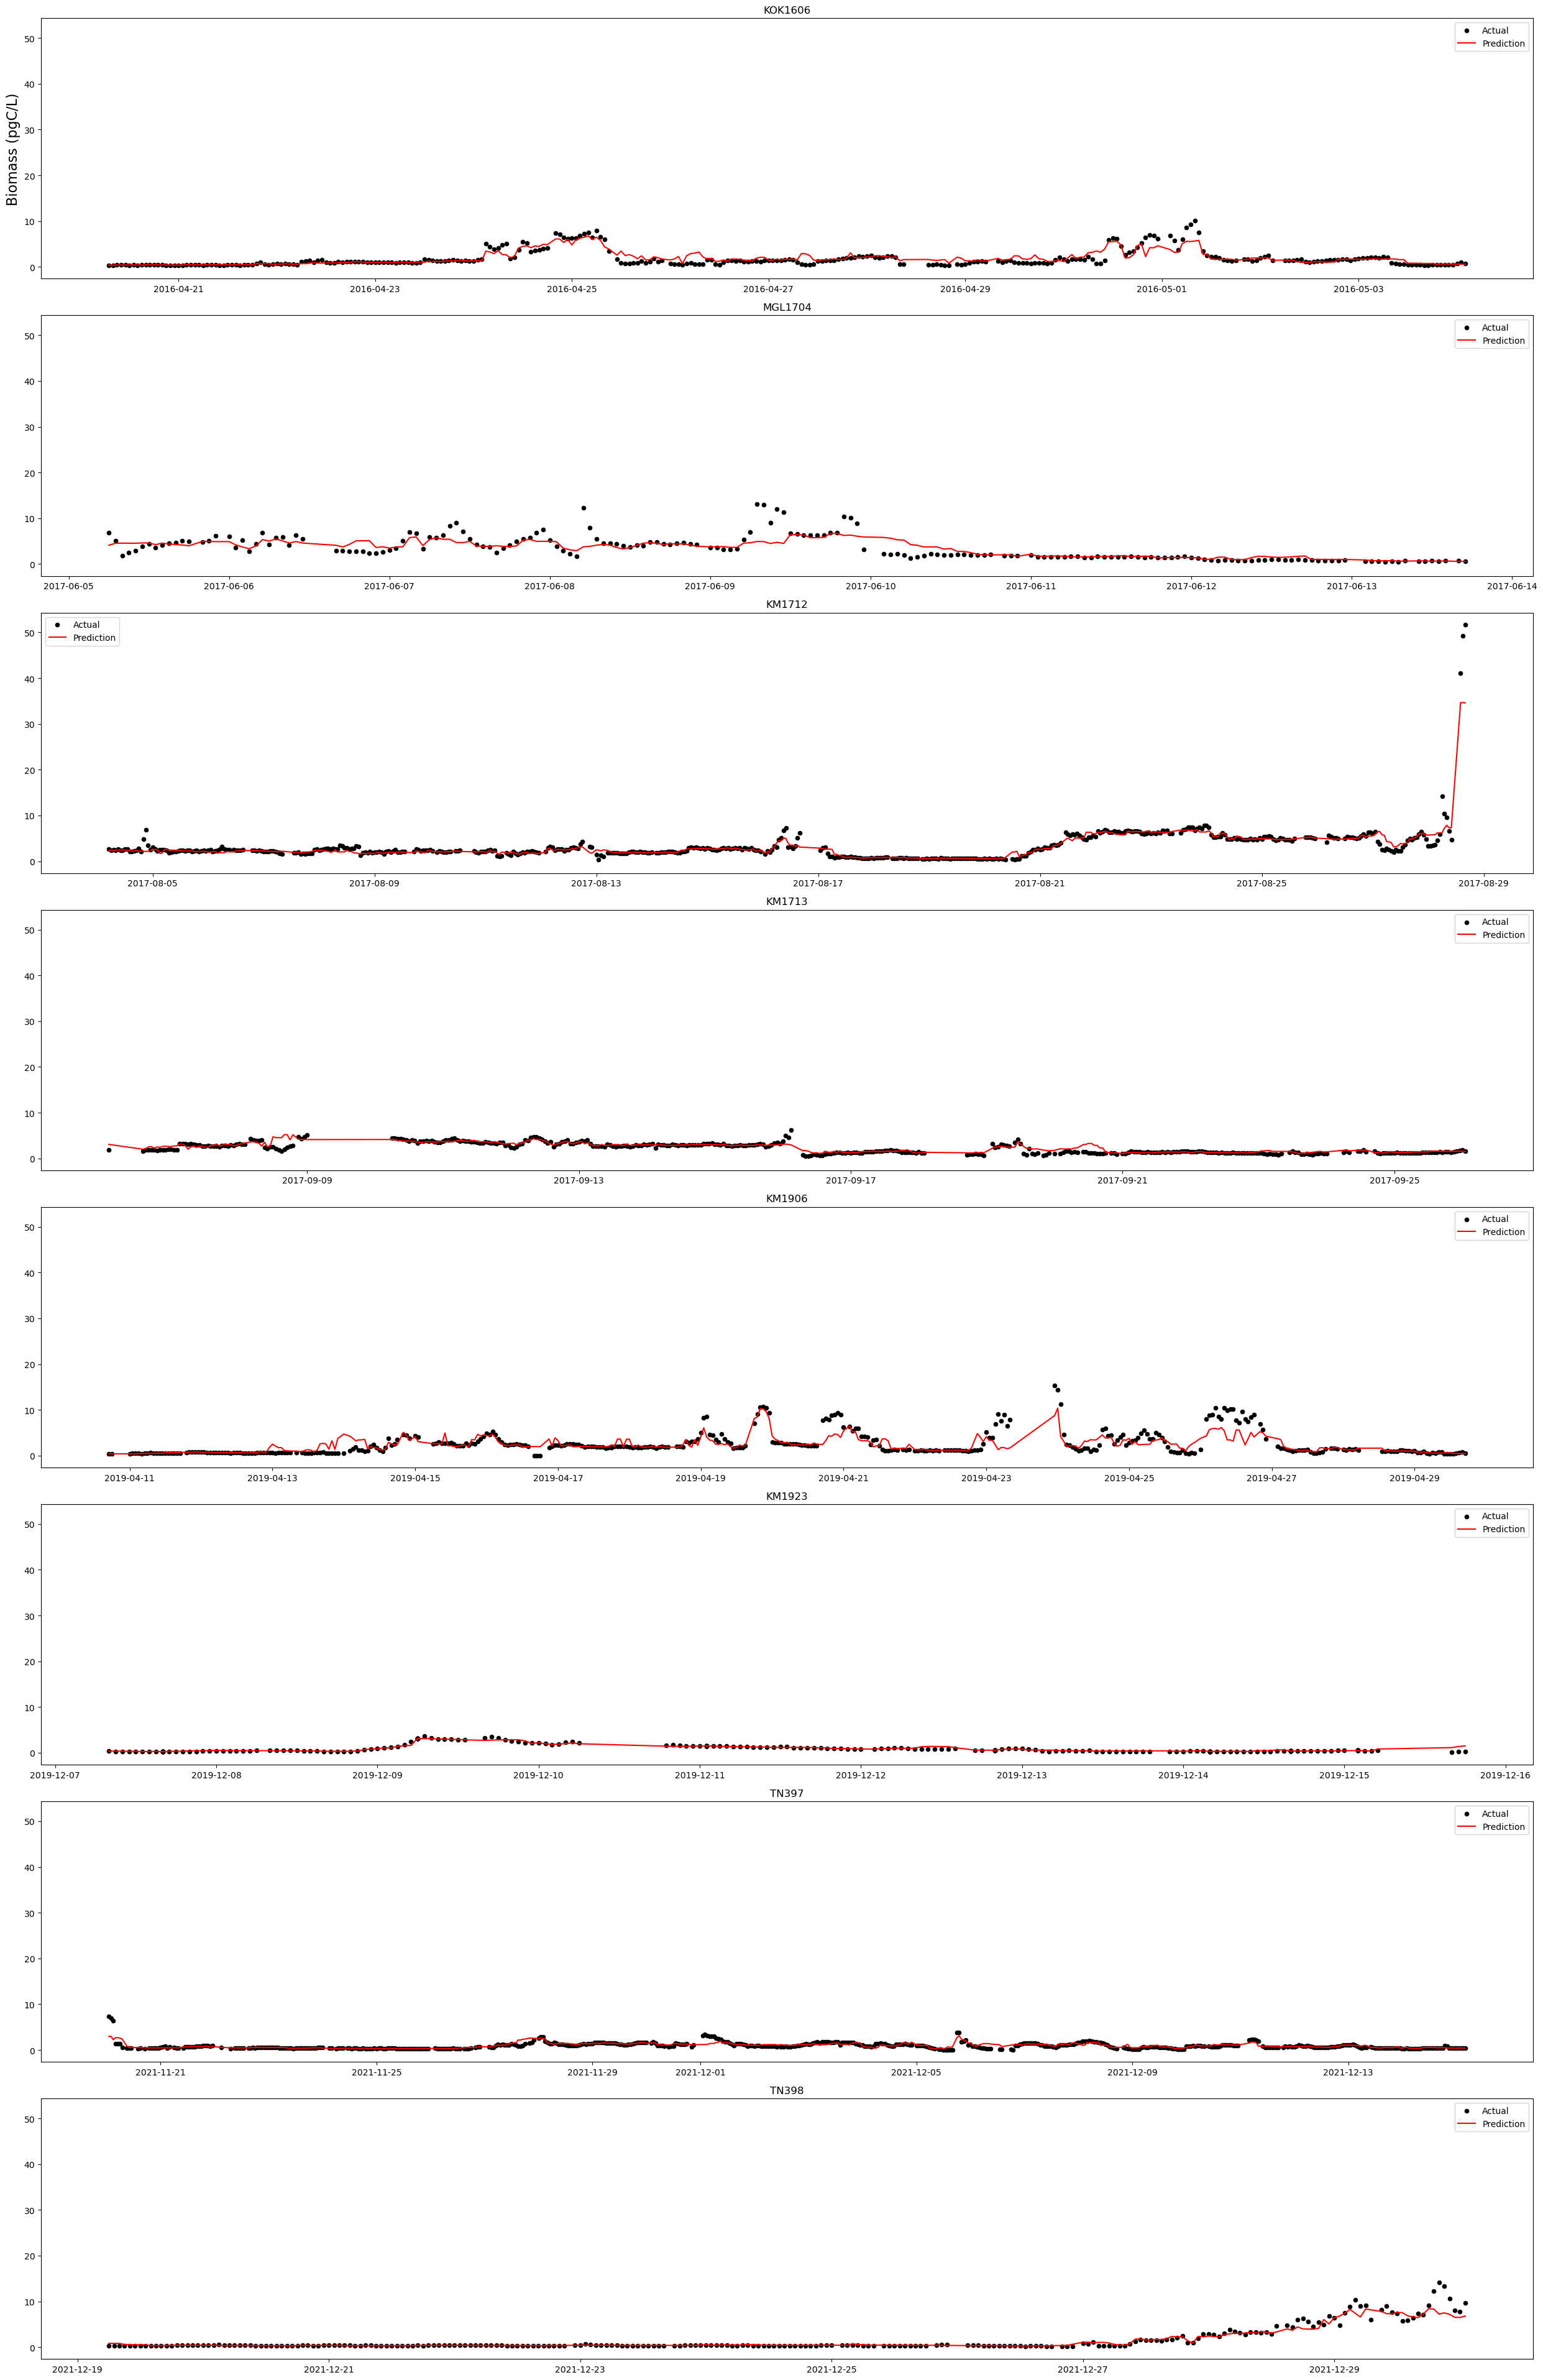

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a list of unique cruise names
unique_cruises = syn_df['cruisename'].unique()

# Create subplots dynamically based on the number of unique cruises
num_subplots = len(unique_cruises)
fig, axs = plt.subplots(nrows=num_subplots, ncols=1, sharey=True, figsize=(25, 40))

# Iterate through unique cruises and create subplots
for i, cruise_name in enumerate(unique_cruises):
    cruise_data = syn_df[syn_df['cruisename'] == cruise_name]
    
    ax = axs[i]
    ax.scatter(cruise_data['time'], cruise_data['actual'], s=20, color='black', label='Actual')
    ax.plot(cruise_data['time'], cruise_data['prediction'], color='red', label='Prediction')
    
    ax.set_title(cruise_name)
    ax.legend()

# Add a common y-axis label (if needed)
axs[0].set_ylabel('Biomass (pgC/L)', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Add space for suptitle
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create two subplots and unpack the output array immediately
f, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharey=False, figsize=(15,10))

km1712_pro = pro_df[pro_df['cruisename'] == 'KM1712']
km1712_syn = syn_df[syn_df['cruisename'] == 'KM1712']
km1712_pico = pico_df[pico_df['cruisename'] == 'KM1712']
km1712_nano = nano_df[nano_df['cruisename'] == 'KM1712']
      
ax1.scatter(km1712_pro['time'], km1712_pro['actual'], s=5, color='black', label='Actual')
ax1.plot(km1712_pro['time'], km1712_pro['prediction'], color='blue', label='Prediction')

ax1.set_title('6A')
ax1.legend()

ax2.scatter(km1712_syn['time'], km1712_syn['actual'], s=5, color='black', label='Actual')
ax2.plot(km1712_syn['time'], km1712_syn['prediction'], color='blue', label='Prediction')

ax2.set_title('6B')
ax2.legend()

ax3.scatter(km1712_pico['time'], km1712_pico['actual'], s=5, color='black', label='Actual')
ax3.plot(km1712_pico['time'], km1712_pico['prediction'], color='blue', label='Prediction')

ax3.set_title('6C')
ax3.legend()

ax4.scatter(km1712_nano['time'], km1712_nano['actual'], s=5, color='black', label='Actual')
ax4.plot(km1712_nano['time'], km1712_nano['prediction'], color='purple', label='Prediction')

ax4.set_title('6D')

f.supylabel('Predicted Biomass (pgC per L)', fontsize=16)
f.supxlabel('Time (1 hour)', fontsize=16)


plt.suptitle('KM1712 Cruise Model Prediction and Actual values', fontsize=24)


plt.tight_layout(rect=[0, 0, 1, 0.96])  # Add space for suptitle
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create two subplots and unpack the output array immediately
f, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharey=False, figsize=(15,10))

km1923_pro = pro_df[pro_df['cruisename'] == 'KM1923']
km1923_syn = syn_df[syn_df['cruisename'] == 'KM1923']
km1923_pico = pico_df[pico_df['cruisename'] == 'KM1923']
km1923_nano = nano_df[nano_df['cruisename'] == 'KM1923']
      
ax1.scatter(km1923_pro['time'], km1923_pro['actual'], s=5, color='black', label='Actual')
ax1.plot(km1923_pro['time'], km1923_pro['prediction'], color='blue', label='Prediction')

ax1.set_title('Prochlorococus')
ax1.legend()

ax2.scatter(km1923_syn['time'], km1923_syn['actual'], s=5, color='black', label='Actual')
ax2.plot(km1923_syn['time'], km1923_syn['prediction'], color='blue', label='Prediction')

ax2.set_title('Synechococcus')
ax2.legend()

ax3.scatter(km1923_pico['time'], km1923_pico['actual'], s=5, color='black', label='Actual')
ax3.plot(km1923_pico['time'], km1923_pico['prediction'], color='blue', label='Prediction')

ax3.set_title('Picoeukaryotes')
ax3.legend()

ax4.scatter(km1923_nano['time'], km1923_nano['actual'], s=5, color='black', label='Actual')
ax4.plot(km1923_nano['time'], km1923_nano['prediction'], color='purple', label='Prediction')

ax4.set_title('Nanoeukaryotes')



f.supylabel('Predicted Biomass (pgC per L)', fontsize=16)
f.supxlabel('Time (1 hour)', fontsize=16)


plt.suptitle('KM1923 Cruise Model Prediction and Actual values', fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Add space for suptitle
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create two subplots and unpack the output array immediately
f, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharey=False, figsize=(15,10))

km1923_pro = pro_df[pro_df['cruisename'] == 'KM1923']
km1923_syn = syn_df[syn_df['cruisename'] == 'KM1923']
km1923_pico = pico_df[pico_df['cruisename'] == 'KM1923']
km1923_nano = nano_df[nano_df['cruisename'] == 'KM1923']
      
ax1.scatter(km1923_pro['lat'], km1923_pro['actual'], s=5, color='black', label='Actual')
ax1.plot(km1923_pro['lat'], km1923_pro['prediction'], color='blue', label='Prediction')

ax1.set_title('6A')
ax1.legend()

ax2.scatter(km1923_syn['lat'], km1923_syn['actual'], s=5, color='black', label='Actual')
ax2.plot(km1923_syn['lat'], km1923_syn['prediction'], color='blue', label='Prediction')

ax2.set_title('6B')


ax3.scatter(km1923_pico['lat'], km1923_pico['actual'], s=5, color='black', label='Actual')
ax3.plot(km1923_pico['lat'], km1923_pico['prediction'], color='blue', label='Prediction')

ax3.set_title('6C')


ax4.scatter(km1923_nano['lat'], km1923_nano['actual'], s=5, color='black', label='Actual')
ax4.plot(km1923_nano['lat'], km1923_nano['prediction'], color='blue', label='Prediction')

ax4.set_title('6D')

f.supylabel('Biomass (pgC per L)', fontsize=20, x=0.01)
f.supxlabel('Latitude (º)', fontsize=24)


plt.suptitle('KM1923 Cruise Model Prediction and Actual values', fontsize=24)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Add space for suptitle
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create two subplots and unpack the output array immediately
f, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharey=True, figsize=(15,10))

tn398_pro = pro_df[pro_df['cruisename'] == 'TN398']
tn398_syn = syn_df[syn_df['cruisename'] == 'TN398']
tn398_pico = pico_df[pico_df['cruisename'] == 'TN398']
tn398_nano = nano_df[nano_df['cruisename'] == 'TN398']
      
ax1.scatter(tn398_pro['lat'], tn398_pro['actual'], s=5, color='black', label='Actual')
ax1.plot(tn398_pro['lat'], tn398_pro['prediction'], color='blue', label='Prediction')

ax1.set_title('6A')
ax1.legend()

ax2.scatter(tn398_syn['lat'], tn398_syn['actual'], s=5, color='black', label='Actual')
ax2.plot(tn398_syn['lat'], tn398_syn['prediction'], color='blue', label='Prediction')

ax2.set_title('6B')


ax3.scatter(tn398_pico['lat'], tn398_pico['actual'], s=5, color='black', label='Actual')
ax3.plot(tn398_pico['lat'], tn398_pico['prediction'], color='blue', label='Prediction')

ax3.set_title('6C')


ax4.scatter(tn398_nano['lat'], tn398_nano['actual'], s=5, color='black', label='Actual')
ax4.plot(tn398_nano['lat'], tn398_nano['prediction'], color='blue', label='Prediction')

ax4.set_title('6D')

f.supylabel('Biomass (pgC per L)', fontsize=20, x=0.01)
f.supxlabel('Latitude (º)', fontsize=24)


plt.suptitle('TN398 Cruise Model Prediction and Actual values', fontsize=24)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Add space for suptitle
plt.show()

### Figure used for poster presentation. Represents the prochlorococus actual vs predicted biomass on two cruises.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create two subplots and unpack the output array immediately
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))


tn398 = pro_df[pro_df['cruisename'] == 'TN398']



ax.scatter(tn398['time'], tn398['actual'], s=20, color='black', label='Actual' )
ax.plot(tn398['time'], tn398['prediction'], color='cyan', linewidth=3, label='Prediction')
ax.set_ylabel('Biomass (pgC/L)', fontsize=24)
ax.set_xlabel('Time (1 hour)', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax.legend()


plt.tight_layout(rect=[0, 0, 1, 0.96])  # Add space for suptitle
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def create_actual_prediction_plots_cruise_color_presentation(pop_df, selected_cruises, title_prefix='Prochlorococcus'):
    """
    Actual vs predicted cruise plots color matched to cruise plots.
    """
    # Create a subplot grid
    num_cruises = len(selected_cruises)
    rows = 2 if num_cruises == 2 else int(num_cruises / 2) + 1
    cols = 2 if num_cruises > 2 else 1

    # Create the Matplotlib figure and gridspec
    fig = plt.figure(figsize=(12, 6*rows))
    gs = gridspec.GridSpec(rows, cols, figure=fig)

    # Define colors for 'actual' and 'prediction' lines
    colors = ['blue', 'purple', 'green', 'brown']

    # Iterate over each selected cruise and plot the 'actual' and 'prediction' data
    for i, cruise in enumerate(selected_cruises):
        # Filter dataframe for the current cruise
        cruise_df = pop_df[pop_df['cruisename'] == cruise]

        # Determine the subplot index
        row = int(i / cols)
        col = i % cols

        # Create the subplot
        ax = fig.add_subplot(gs[row, col])

        # Plot 'actual' and 'prediction' data
        ax.plot(cruise_df['time'], cruise_df['actual'], 'ko', label='Actual')
        ax.plot(cruise_df['time'], cruise_df['prediction'], color=colors[i], label='Prediction')
        ax.set_xlabel('Time (1 hour)')
        ax.set_ylabel('Biomass (pgC/L)')
        ax.set_title(cruise)
        ax.legend()

    # Adjust layout and display the figure
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Add space for suptitle
    plt.show()

    # Optionally, save the figure to a file
    fig.savefig(f"figures/{title_prefix}/Actual_vs_Prediction-{title_prefix}.png")


In [ ]:
selected_cruises = ['TN398', 'KM1923']
create_actual_prediction_plots_cruise_color_presentation(pop_df=pro_df,
                                            title_prefix='Prochlorococcus',
                                            selected_cruises=selected_cruises)

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def create_actual_prediction_plots_sample_1day(pop_df, title_prefix='Prochlorococcus'):
    """
    Actual vs predicted plot of biomass over all available cruises averaged to a one day sample
    """
    unique_cruises = pop_df['cruisename'].unique()

    # Create a subplot grid
    num_cruises = len(unique_cruises)
    rows = int(num_cruises / 2) if num_cruises % 2 == 0 else int(num_cruises / 2) + 1
    fig = make_subplots(rows=rows, cols=2, subplot_titles=unique_cruises)

    # Define colors for 'actual' and 'prediction' traces
    actual_color = 'blue'
    prediction_color = 'red'

    # Iterate over each unique cruise and add a subplot
    for i, cruise in enumerate(unique_cruises):
        # Filter dataframe for the current cruise
        cruise_df = pop_df[pop_df['cruisename'] == cruise]
        cruise_df = cruise_df.resample('1440min', on='time').mean(numeric_only=True).reset_index()


        # Add the scatter plots for 'actual' and 'prediction' to the subplot
        row = int(i / 2) + 1
        col = i % 2 + 1
        fig.add_trace(go.Scatter(x=cruise_df['time'], y=cruise_df['actual'], mode='markers', name='Actual',
                                 marker=dict(color=actual_color)),
                      row=row, col=col)
        fig.add_trace(go.Scatter(x=cruise_df['time'], y=cruise_df['prediction'], mode='lines', name='Prediction',
                                 line=dict(color=prediction_color)),
                      row=row, col=col)
        fig.update_xaxes(title_text='Time', row=row, col=col)
        fig.update_yaxes(title_text='Value', row=row, col=col)

    # Update the layout and display the figure
    fig.update_layout(height=600 * rows, width=800, title_text='Daily Averaged Actual and Prediction for Each Cruise')
    fig.show()
    
    fig.write_html(f"figures/{title_prefix}/Actual_vs_Prediction_1Day-{title_prefix}.html")


In [ ]:
create_actual_prediction_plots_sample_1day(pop_df=pro_df, title_prefix='Prochlorococcus')
create_actual_prediction_plots_sample_1day(pop_df=syn_df, title_prefix='Synechococcus')
create_actual_prediction_plots_sample_1day(pop_df=nano_df, title_prefix='Nanoeukaryotes')
create_actual_prediction_plots_sample_1day(pop_df=pico_df, title_prefix='Picoeukaryotes')

In [ ]:
import plotly.graph_objects as go

def create_globe_scatter_plot(pop_df, title_prefix="Prochlorococcus", start_lat=0, start_lon=0):
    """
    Color dot plot on globe of residuals of the population's dataframe
    """
    # Create a 3D scatter plot on a globe
    fig = go.Figure(data=go.Scattergeo(
        lat=pop_df['lat'],
        lon=pop_df['lon'],
        mode='markers',
        marker=dict(
            size=4,
            color=pop_df['residuals'],
            colorscale='Spectral',
            cmin=-50,
            cmax=50,
            colorbar=dict(title='Residuals (%)')
        )
    ))

    # Set the projection type to 'orthographic' for a globe, fitbounds centers the plot on data
    fig.update_geos(projection_type='orthographic', fitbounds="locations")
    # Set the title
    title = f"{title_prefix} Biomass Residuals"
    fig.update_layout(title=title)

    # Show the figure
    fig.show()
    f"{title_prefix} Biomass Residuals"
    fig.write_html(f"figures/{title_prefix}/globe_heatmap-residuals_{title_prefix}.html")


In [ ]:
create_globe_scatter_plot(pop_df=pro_df, title_prefix='Prochlorococcus')
create_globe_scatter_plot(pop_df=syn_df, title_prefix='Synechococcus')
create_globe_scatter_plot(pop_df=pico_df, title_prefix='Picoeukaryotes')
create_globe_scatter_plot(pop_df=nano_df, title_prefix='Nanoeukaryotes')

In [ ]:
import numpy as np
import plotly.graph_objects as go

def create_globe_scatter_plot_1deg_binned(pop_df, title_prefix="Prochlorococcus", start_lat=0, start_lon=0):
    """
    Color dot plot on globe of residuals of the population's dataframe in one degree bins
    """
    # Round latitude and longitude values to the nearest degree
    lat_bins = np.round(pop_df['lat'])
    lon_bins = np.round(pop_df['lon'])

    # Create a new DataFrame with the binned latitude and longitude values
    binned_df = pop_df.copy()
    binned_df['lat_bins'] = lat_bins
    binned_df['lon_bins'] = lon_bins

    # Group the data by latitude and longitude bins and calculate the average residuals
    grouped_df = binned_df.groupby(['lat_bins', 'lon_bins']).mean().reset_index()

    # Create a 3D scatter plot on a globe
    fig = go.Figure(data=go.Scattergeo(
        lat=grouped_df['lat_bins'],
        lon=grouped_df['lon_bins'],
        mode='markers',
        marker=dict(
            size=4,
            color=grouped_df['residuals'],
            colorscale='Spectral',
            cmin=-50,
            cmax=50,
            colorbar=dict(title='Residuals (%)')
        )
    ))

    # Set the projection type to 'orthographic' for a globe, fitbounds centers the plot on data
    fig.update_geos(projection_type='orthographic', fitbounds="locations")
    # Set the title
    title = f"{title_prefix} Biomass Residuals"
    fig.update_layout(title=title)

    # Show the figure
    fig.show()
    fig.write_html(f"figures/{title_prefix}/globe_heatmap-residuals_1deg_binned_{title_prefix}.html")


In [ ]:
create_globe_scatter_plot_1deg_binned(pop_df=pro_df, title_prefix='Prochlorococcus')
create_globe_scatter_plot_1deg_binned(pop_df=syn_df, title_prefix='Synechococcus')
create_globe_scatter_plot_1deg_binned(pop_df=pico_df, title_prefix='Picoeukaryotes')
create_globe_scatter_plot_1deg_binned(pop_df=nano_df, title_prefix='Nanoeukaryotes')

### Creating Sklearn's  feature importance ranking for each populations Random Forest model

In [49]:


# Prochlorococcus
feature_importance_pro = pd.DataFrame(rf_pro.feature_importances_, index=feature_list_pro, columns=['importance'])
feature_importance_pro['std'] = np.std([rf_pro.feature_importances_ for tree in rf_pro.estimators_], axis=0)

# Synechococcus
feature_importance_syn = pd.DataFrame(rf_syn.feature_importances_, index=feature_list_syn, columns=['importance'])
feature_importance_syn['std'] = np.std([rf_syn.feature_importances_ for tree in rf_syn.estimators_], axis=0)

# Picoeukaryotes
feature_importance_pico = pd.DataFrame(rf_pico.feature_importances_, index=feature_list_pico, columns=['importance'])
feature_importance_pico['std'] = np.std([rf_pico.feature_importances_ for tree in rf_pico.estimators_], axis=0)


# Nanoeukaryotes
feature_importance_nano = pd.DataFrame(rf_nano.feature_importances_, index=feature_list_nano, columns=['importance'])
feature_importance_nano['std'] = np.std([rf_nano.feature_importances_ for tree in rf_nano.estimators_], axis=0)


In [57]:
feature_importance_nano

importance           std
salin    0.133375  1.942890e-16
temp     0.093539  0.000000e+00
SiO2     0.014893  1.908196e-17
POC      0.017404  1.734723e-17
PO4      0.062802  8.326673e-17
PIC      0.024405  1.734723e-17
O2       0.063455  2.775558e-17
NO3      0.023762  3.469447e-18
NO2      0.044904  7.632783e-17
NH4      0.013118  2.255141e-17
FeT      0.047542  6.245005e-17
DOC      0.039198  3.469447e-17
DIC      0.183976  5.551115e-17
CDOM     0.112477  1.942890e-16
ALK      0.102443  1.526557e-16
par      0.022706  2.775558e-17

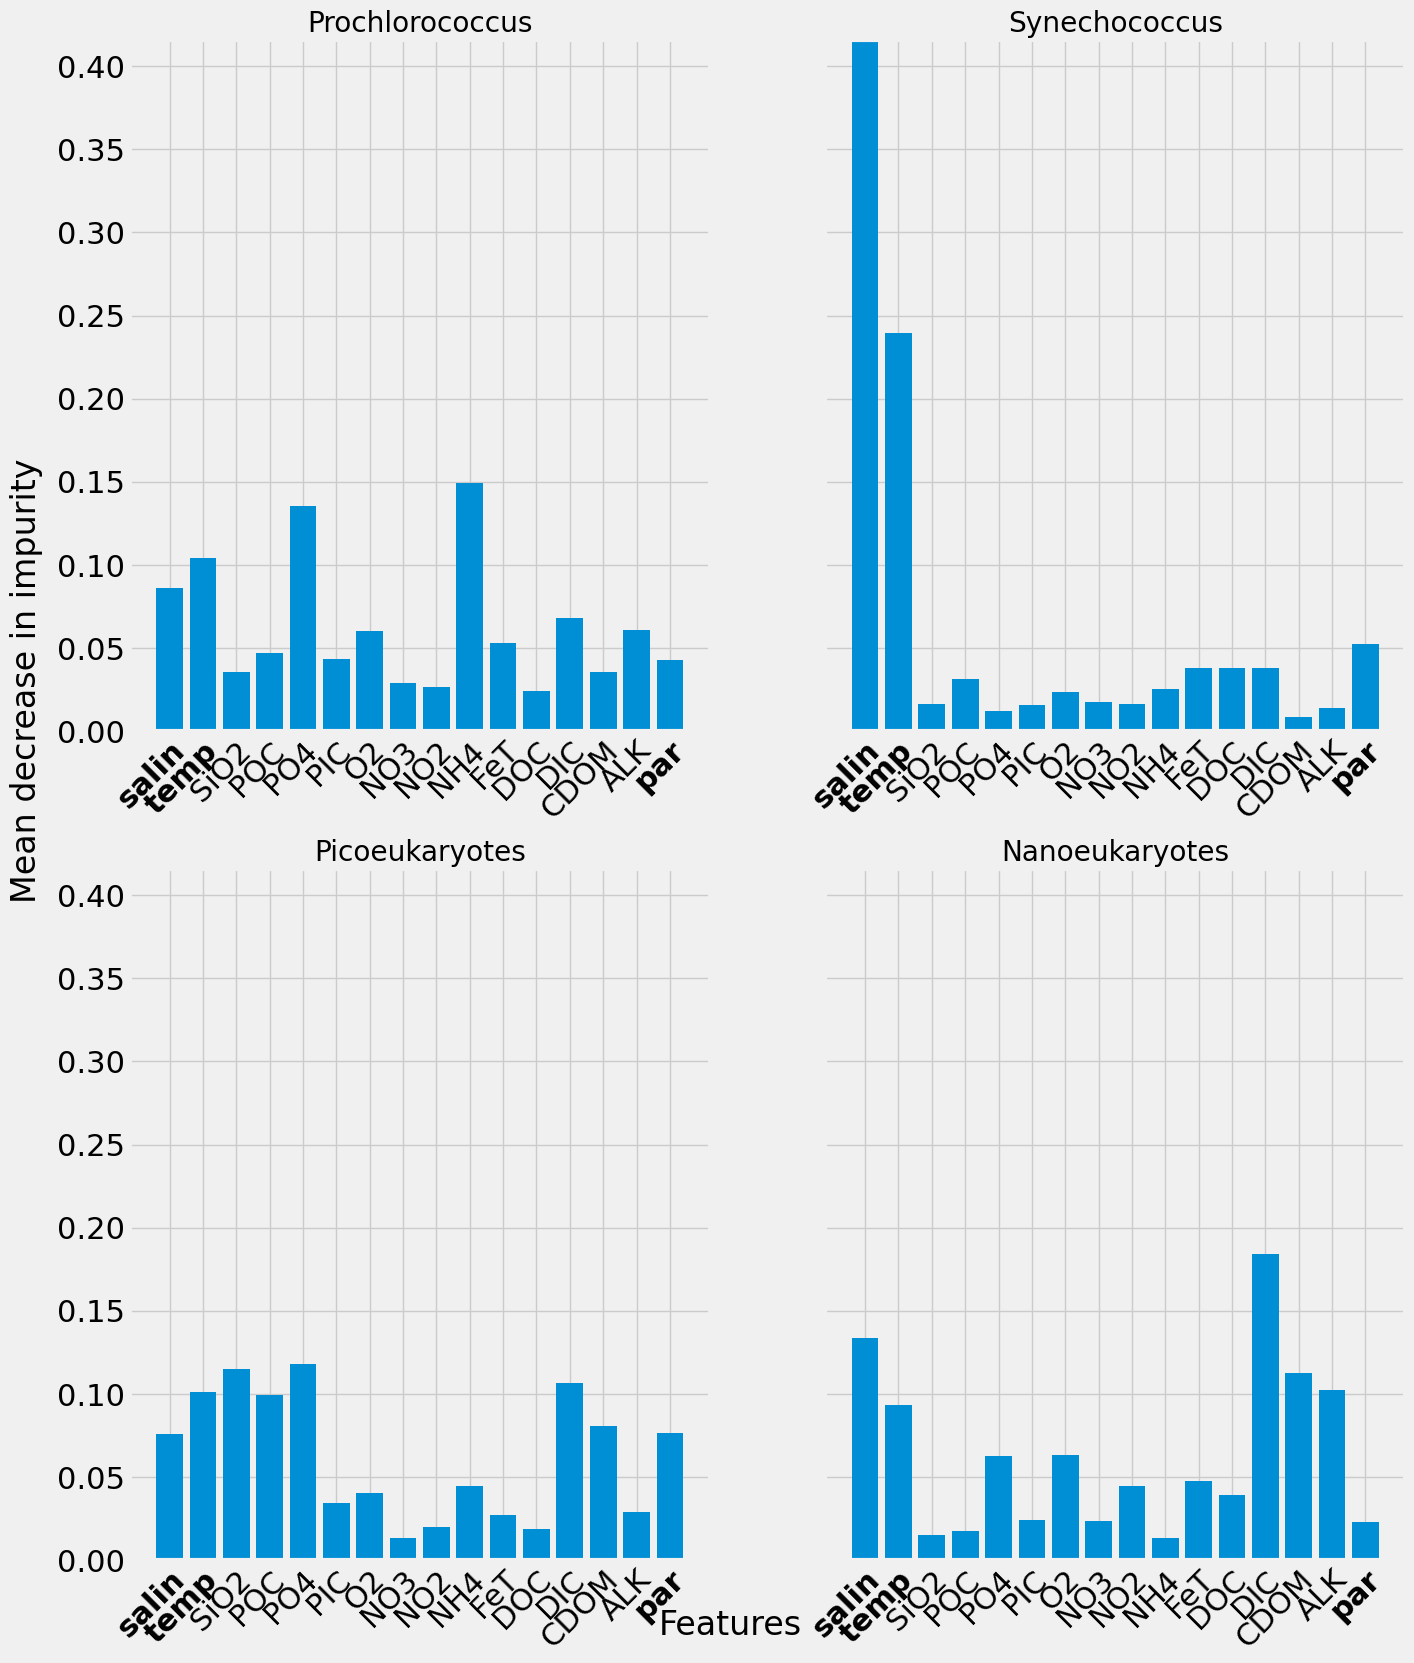

In [55]:
# Create four polar axes and access them through the returned array -- Shared Y Axis!
fig, axs = plt.subplots(2, 2, sharey='row', figsize=(15, 8))

populations = ['Prochlorococcus', 'Synechococcus', 'Picoeukaryotes', 'Nanoeukaryotes']
feature_importance_list = [feature_importance_pro, feature_importance_syn, feature_importance_pico, feature_importance_nano]

# Iterate through each population and plot feature importance
for i, population in enumerate(populations):
    # Plotting feature importance
    ax = axs[i // 2, i % 2]
    ax.bar(x=feature_importance_list[i].index, height=feature_importance_list[i]['importance'],
           yerr=feature_importance_list[i]['std'].values, orientation='vertical')
    # Aligning x tickswhat 
    x_labels = feature_importance_list[i].index
    
    # Make specific x-axis labels bold
    bold_x_labels = ['temp', 'salin', 'par']
    ax.set_xticks(range(len(x_labels)))
    ax.set_xticklabels(x_labels, rotation=45, ha='right', rotation_mode='anchor', fontsize=10)  # Adjust the fontsize
    
    for tick_label in ax.get_xticklabels():
        if tick_label.get_text() in bold_x_labels:
            tick_label.set_weight('bold')

    ax.set_title(population)
    
    # Adjust font size of x and y axis labels
    ax.tick_params(axis='both', which='major', labelsize=22)  # Adjust the fontsize

    # Find the maximum feature importance value for all populations
    max_importance_value = max([feature_importance_list[j]['importance'].max() for j in range(len(populations))])

    # Set the y-axis limits for each subplot to be the same (using the maximum value)
    ax.set_ylim(0, max_importance_value)



plt.subplots_adjust(left=0.1, right=0.95, top=2, bottom=0.1)  # Adjust the padding as needed
plt.style.use('fivethirtyeight')
# Set common x and y labels for the entire set of subplots
fig.text(0.5, 0.007, 'Features', ha='center', fontsize=24)
fig.text(0.02, 1.2, 'Mean decrease in impurity', va='center', rotation='vertical', fontsize=24)


plt.show()

In [ ]:
from sklearn.inspection import permutation_importance 
permutation_importance(rf_pro, X_val, y_val, n_repeats=30, random_state=0)


In [ ]:
from sklearn.inspection import permutation_importance 
# Prochlorococcus
feature_importance_pro = pd.DataFrame(rf_pro.feature_importances_, index=feature_list_pro).sort_values(by=0, ascending=False)

# Synechococcus
feature_importance_syn = pd.DataFrame(rf_syn.feature_importances_, index=feature_list_syn).sort_values(by=0, ascending=False)

# Picoeukaryotes
feature_importance_pico = pd.DataFrame(rf_pico.feature_importances_, index=feature_list_pico).sort_values(by=0, ascending=False)

# Nanoeukaryotes
feature_importance_nano = pd.DataFrame(rf_nano.feature_importances_, index=feature_list_nano).sort_values(by=0, ascending=False)


KeyError: 0

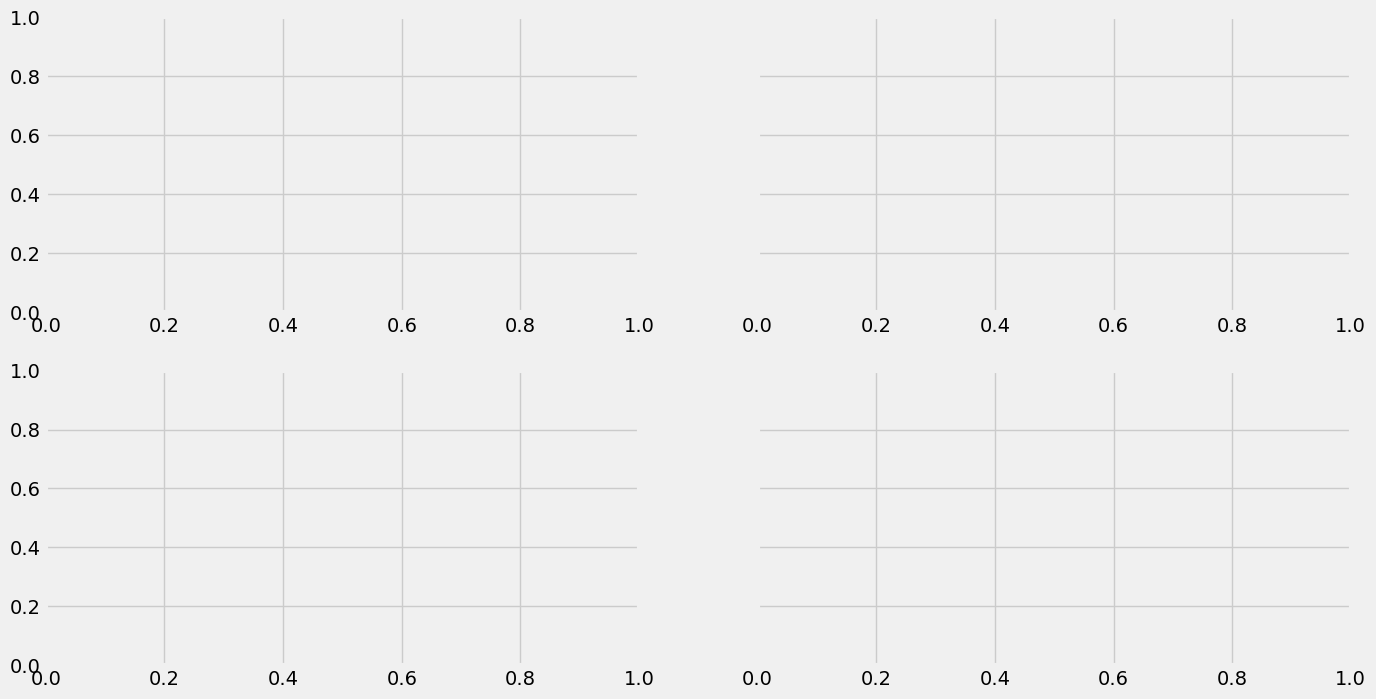

In [58]:
# Create four polar axes and access them through the returned array -- Shared Y Axis!
fig, axs = plt.subplots(2, 2, sharey='row', figsize=(15, 8))

populations = ['Prochlorococcus', 'Synechococcus', 'Picoeukaryotes', 'Nanoeukaryotes']
feature_importance_list = [feature_importance_pro, feature_importance_syn, feature_importance_pico, feature_importance_nano]

# Iterate through each population and plot feature importance
for i, population in enumerate(populations):
    # Plotting feature importance
    ax = axs[i // 2, i % 2]
    ax.bar(x=feature_importance_list[i].index, height=feature_importance_list[i][0], orientation='vertical')
    # Aligning x tickswhat 
    x_labels = feature_importance_list[i].index
    
    # Make specific x-axis labels bold
    bold_x_labels = ['temp', 'salin', 'par']
    ax.set_xticks(range(len(x_labels)))
    ax.set_xticklabels(x_labels, rotation=45, ha='right', rotation_mode='anchor', fontsize=10)  # Adjust the fontsize
    
    for tick_label in ax.get_xticklabels():
        if tick_label.get_text() in bold_x_labels:
            tick_label.set_weight('bold')

    ax.set_title(population)
    
    # Adjust font size of x and y axis labels
    ax.tick_params(axis='both', which='major', labelsize=22)  # Adjust the fontsize

    # Find the maximum feature importance value for all populations
    max_importance_value = max([feature_importance_list[j][0].max() for j in range(len(populations))])

    # Set the y-axis limits for each subplot to be the same (using the maximum value)
    ax.set_ylim(0, max_importance_value)



plt.subplots_adjust(left=0.1, right=0.95, top=2, bottom=0.1)  # Adjust the padding as needed
plt.style.use('fivethirtyeight')
# Set common x and y labels for the entire set of subplots
fig.text(0.5, 0.007, 'Features', ha='center', fontsize=24)
fig.text(0.02, 1.2, 'Mean decrease in impurity', va='center', rotation='vertical', fontsize=24)


plt.show()